# SpO2 measurement



## import module and declare function

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms


def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)




## Main function

c:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


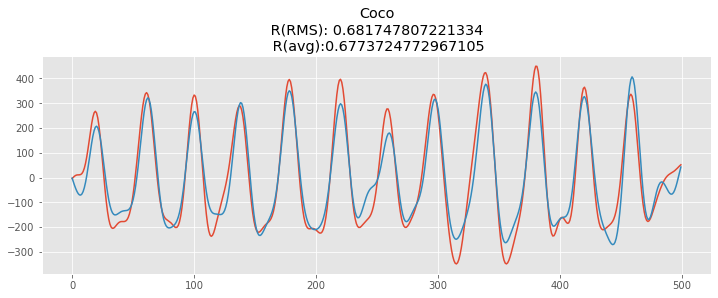

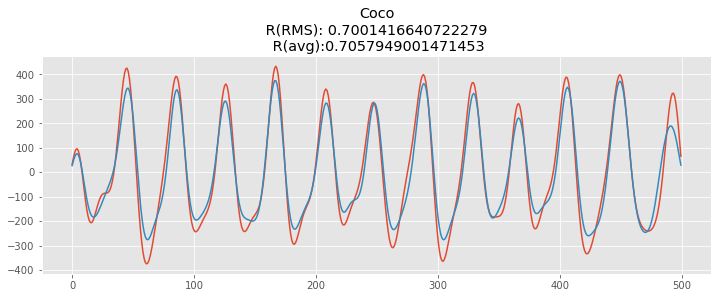

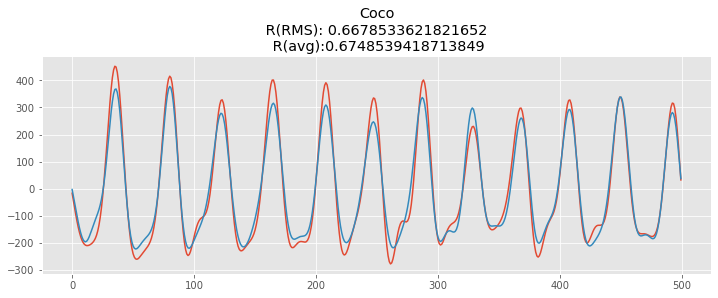

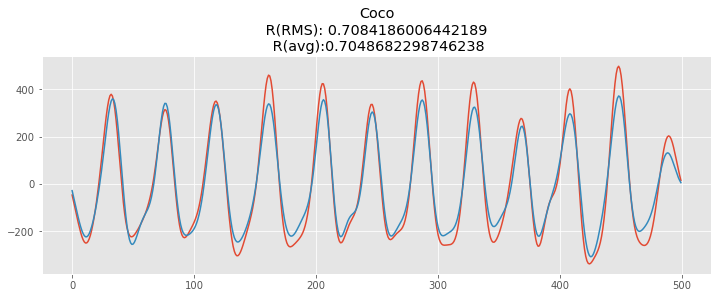

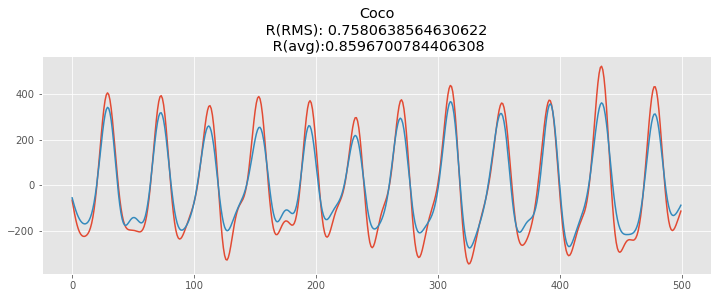

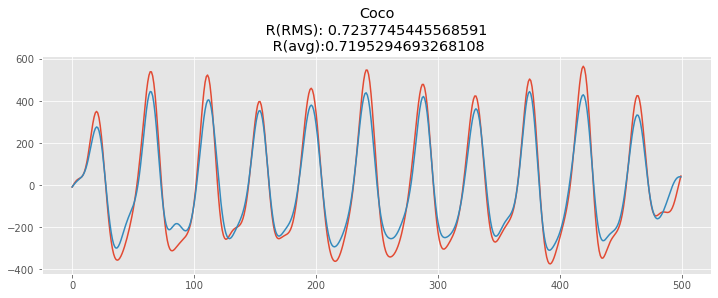

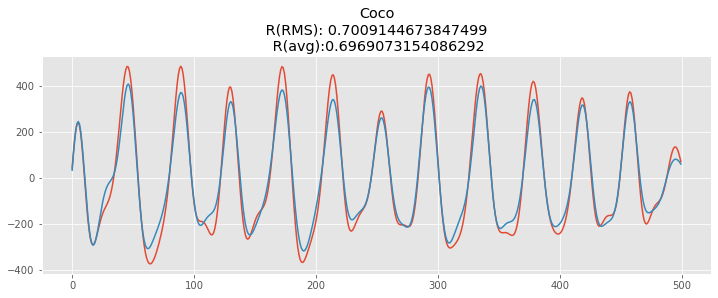

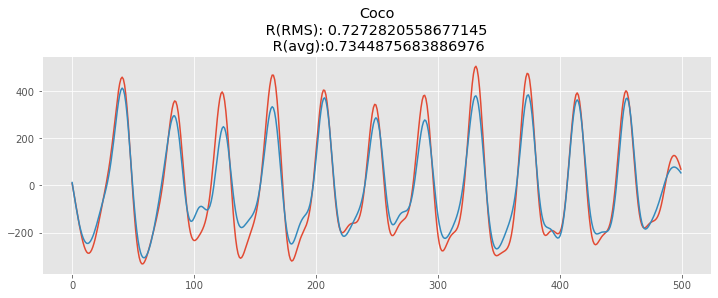

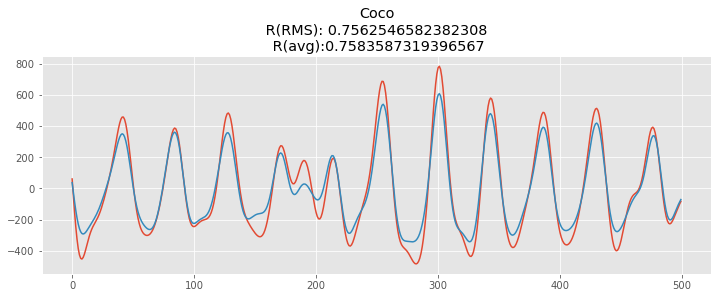

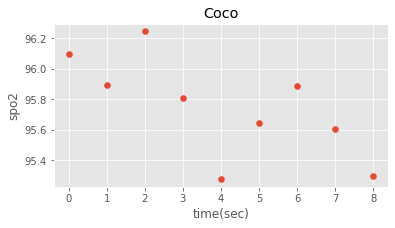

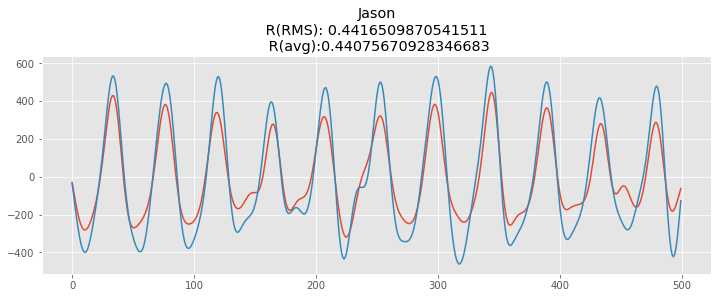

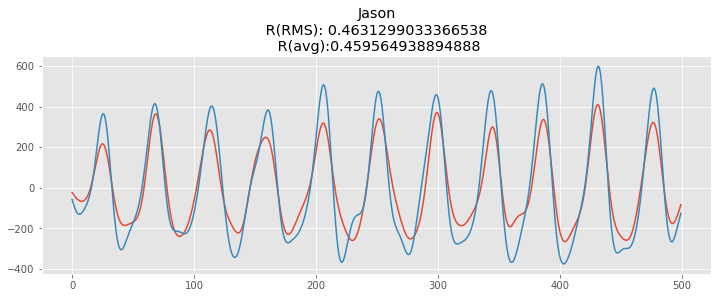

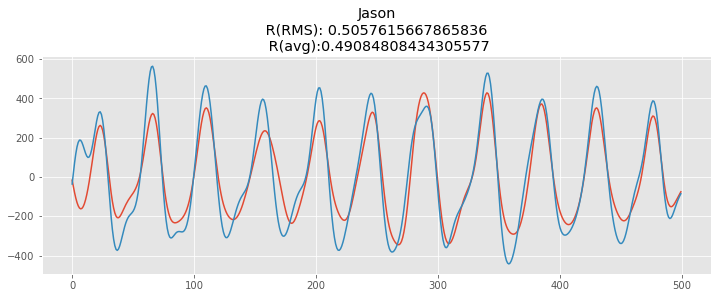

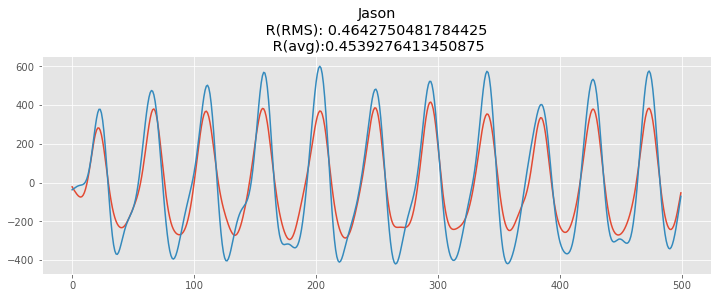

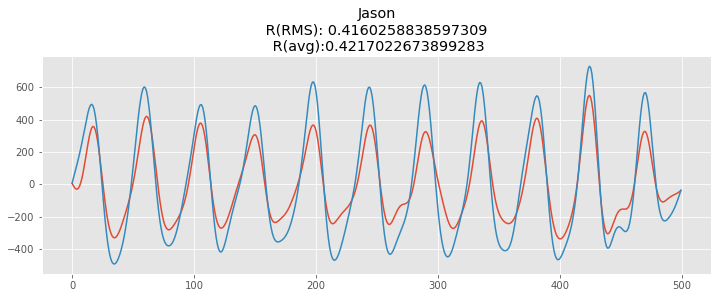

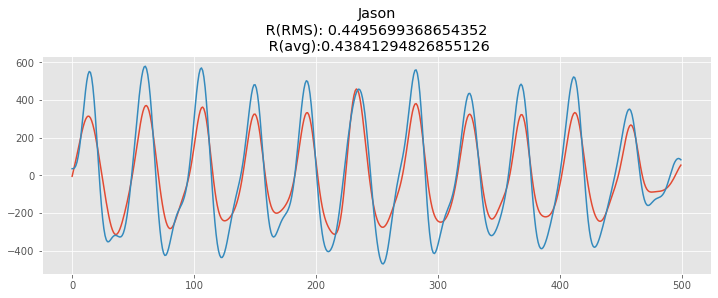

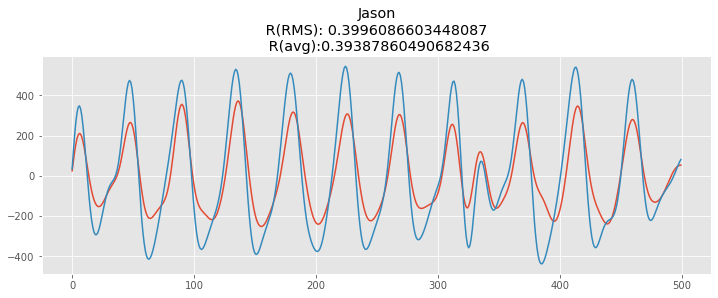

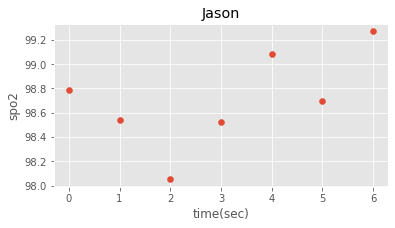

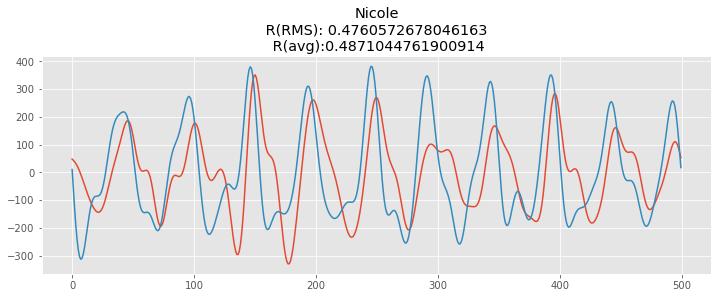

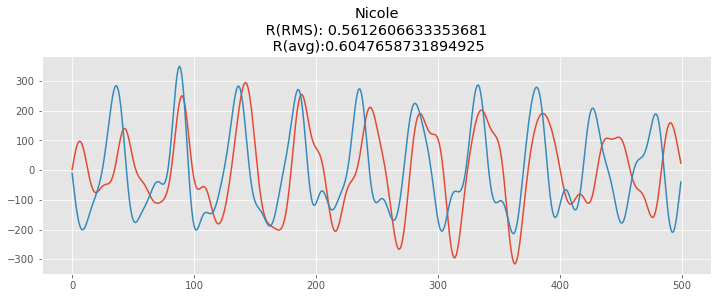

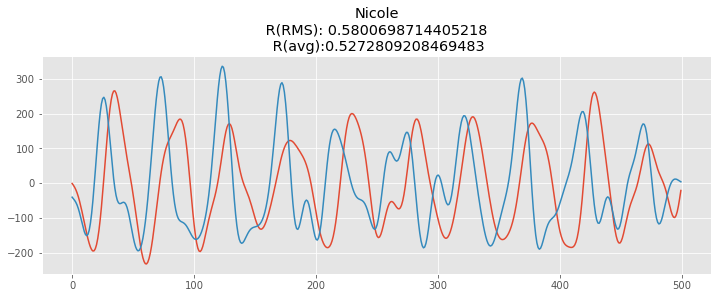

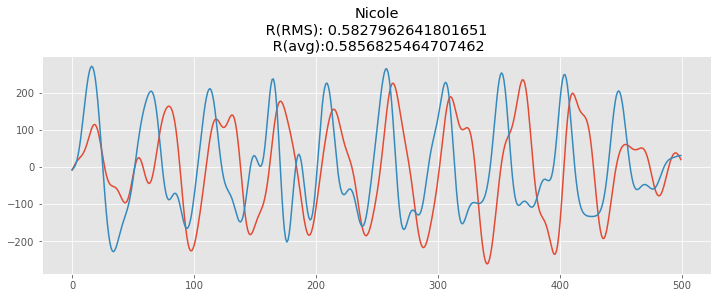

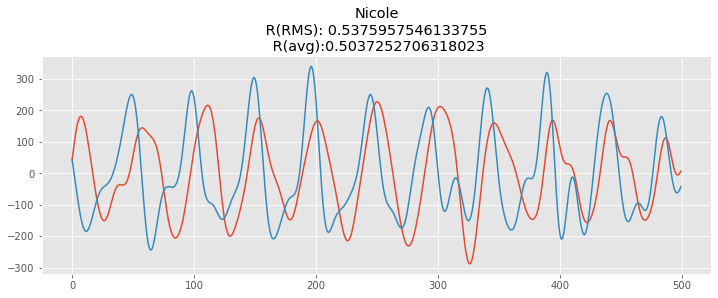

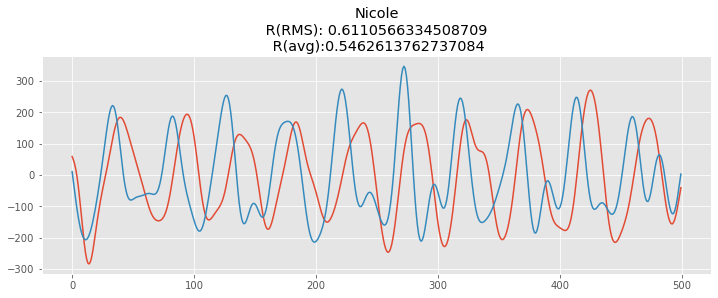

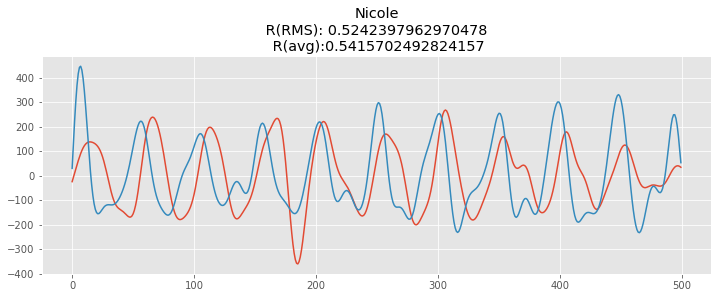

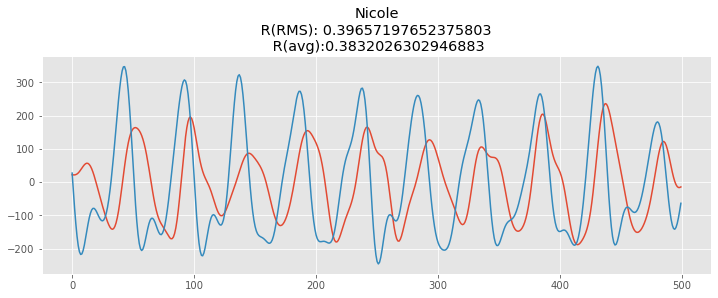

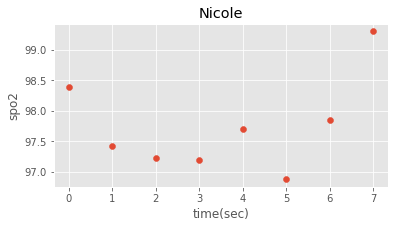

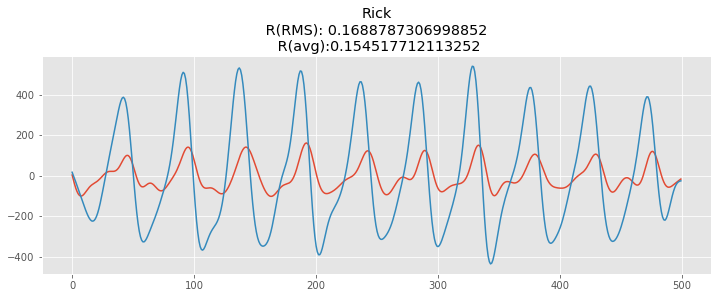

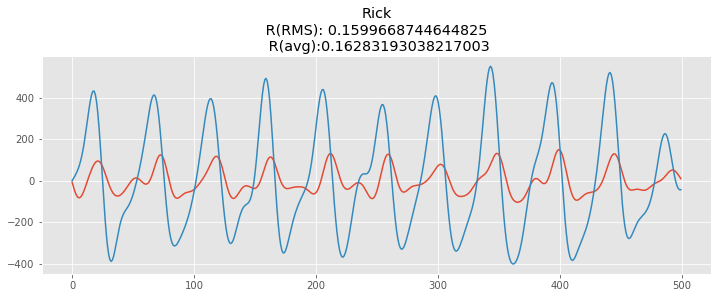

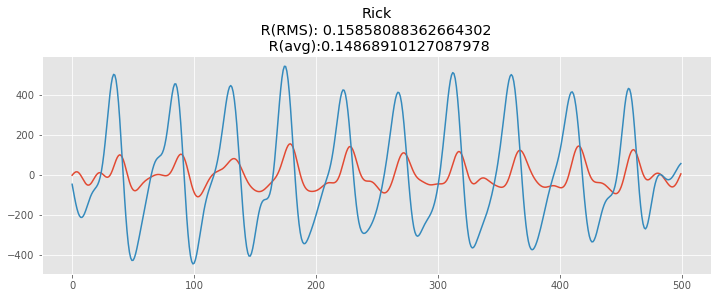

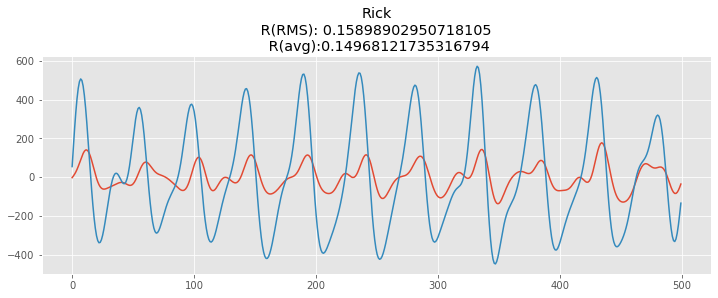

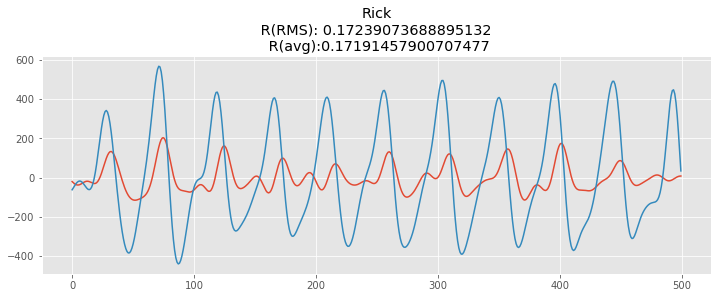

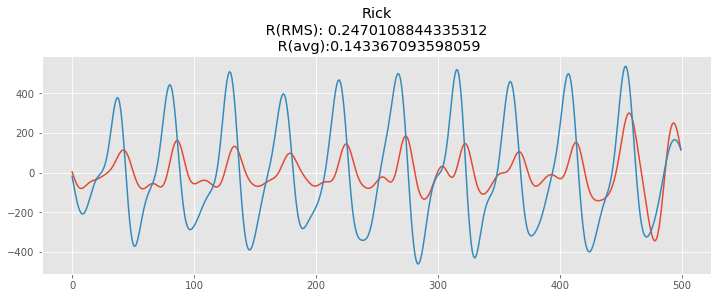

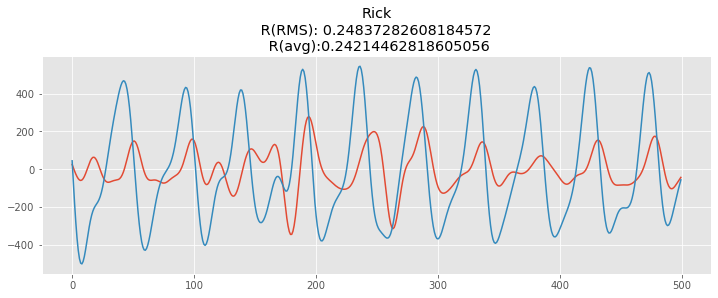

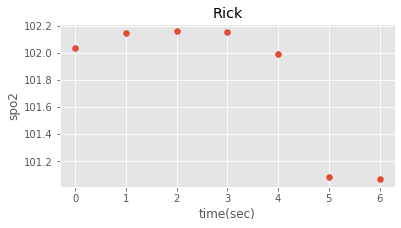

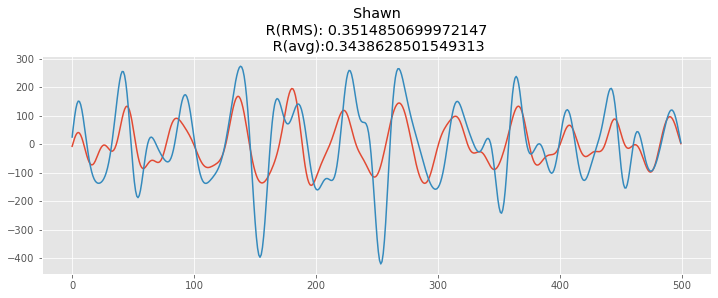

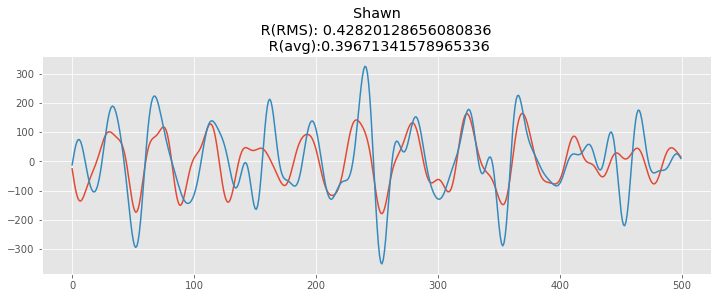

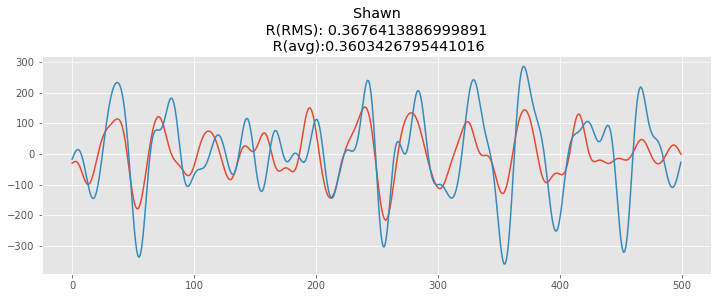

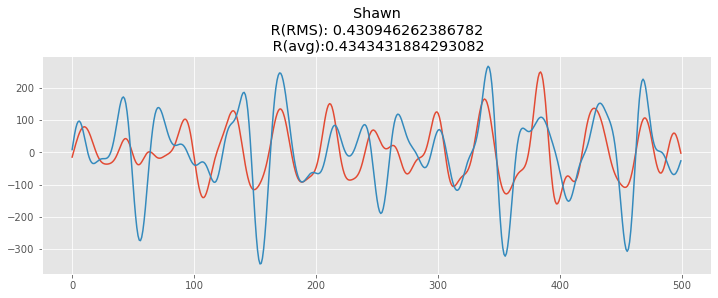

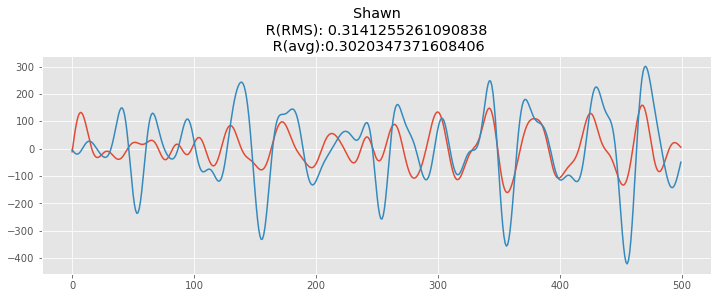

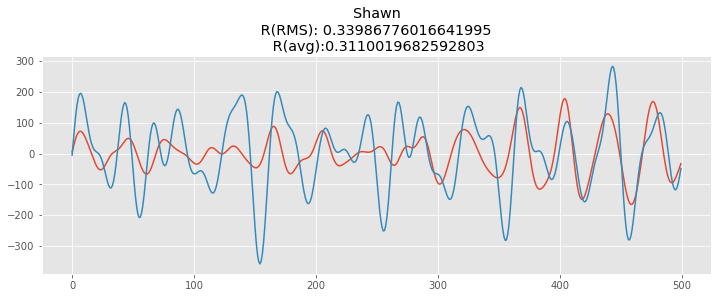

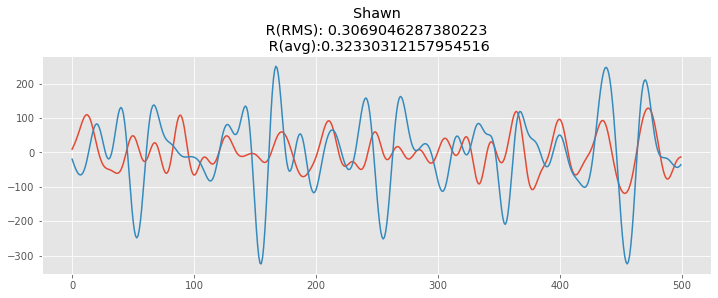

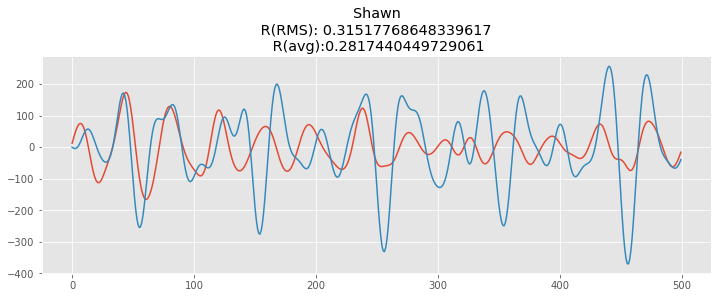

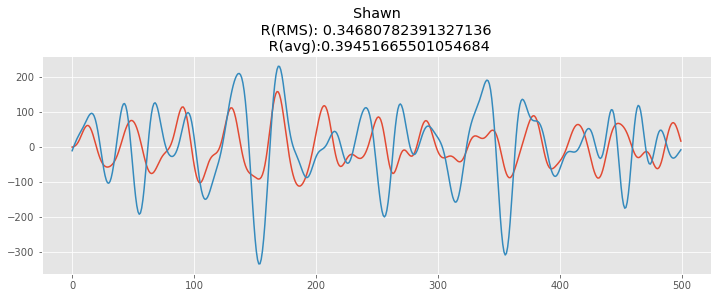

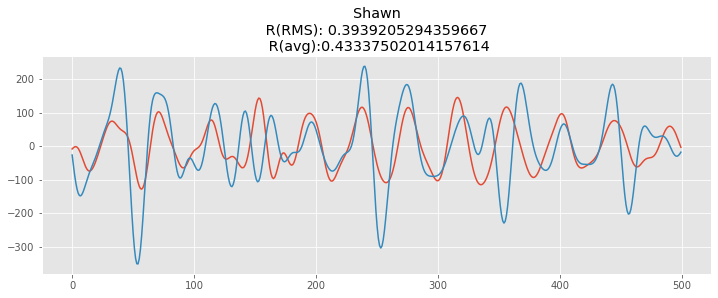

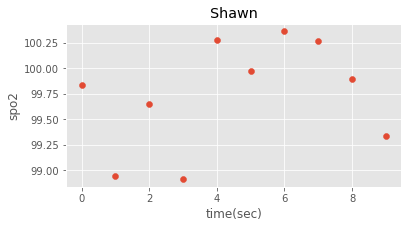

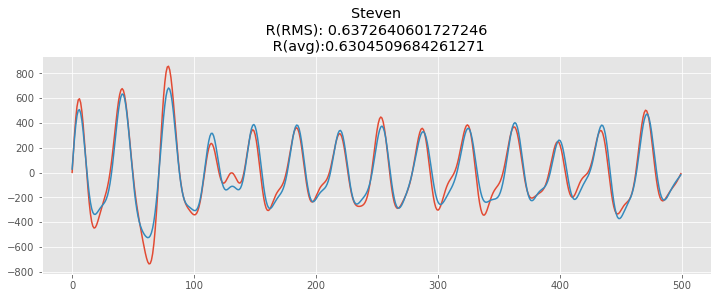

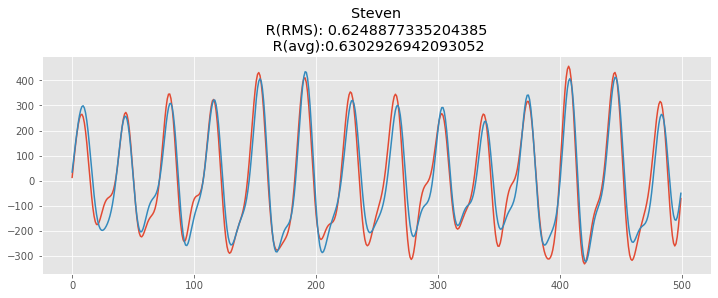

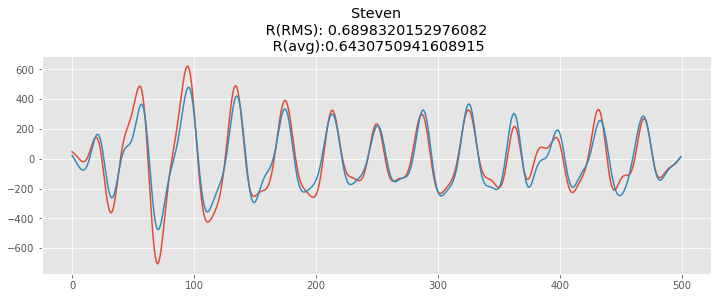

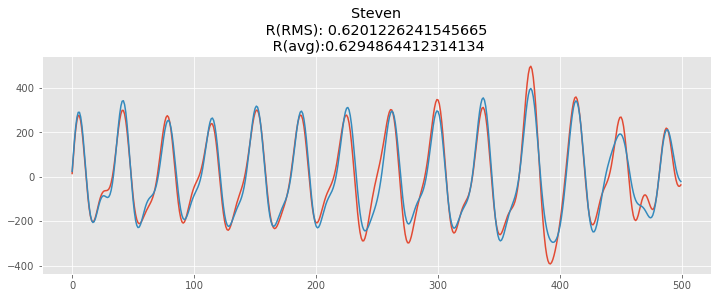

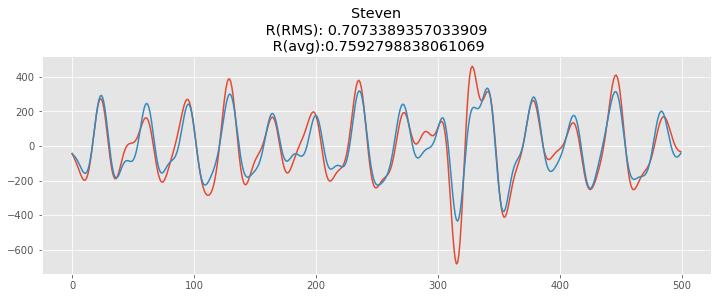

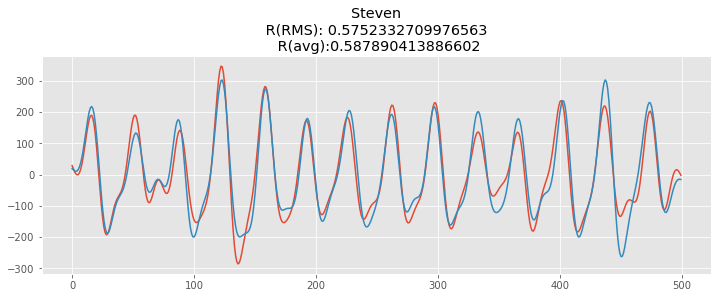

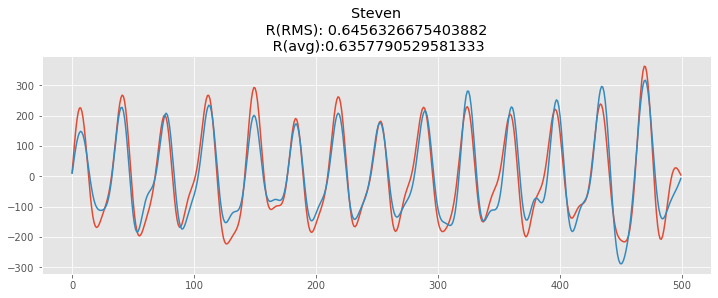

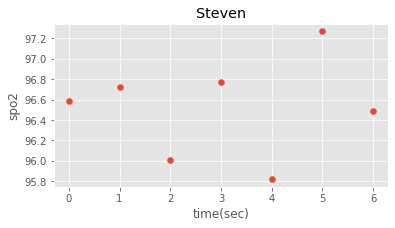

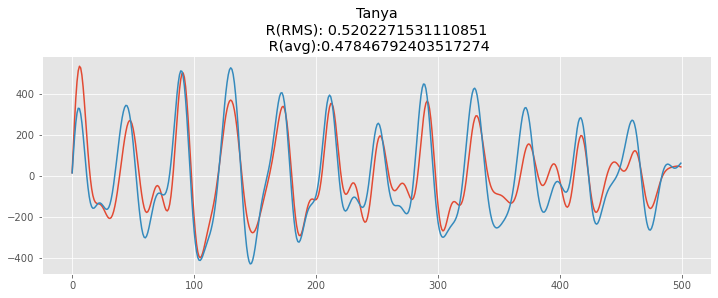

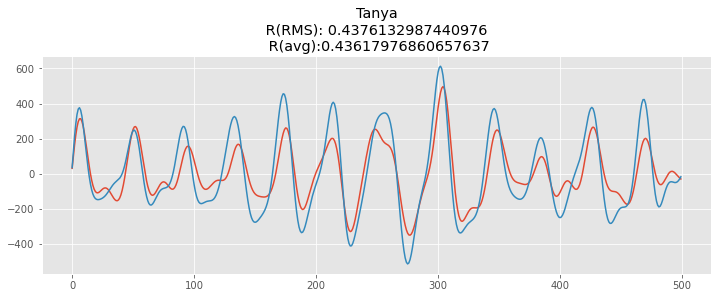

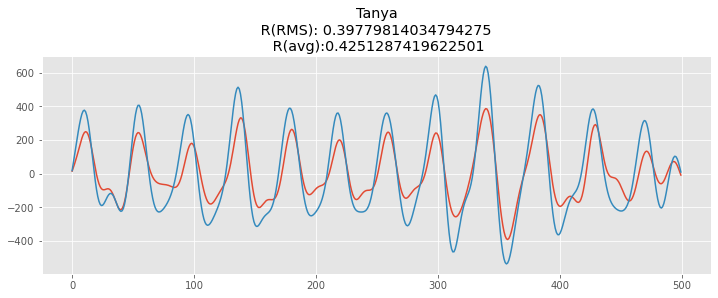

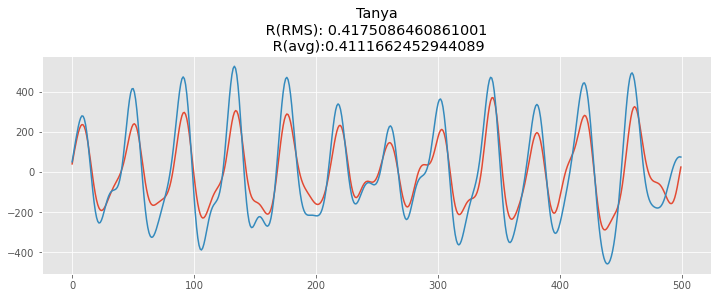

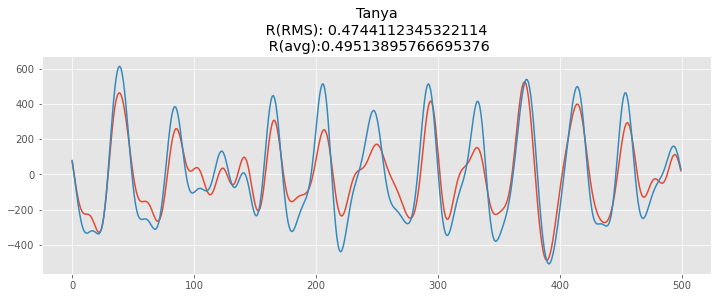

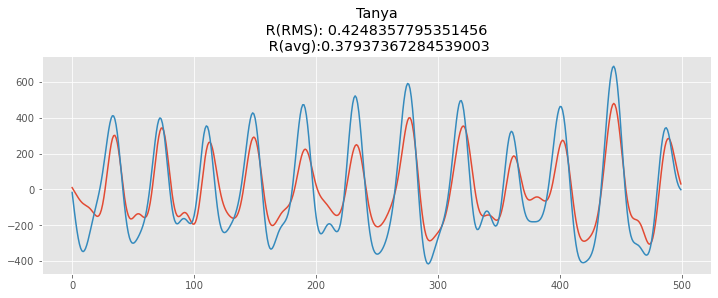

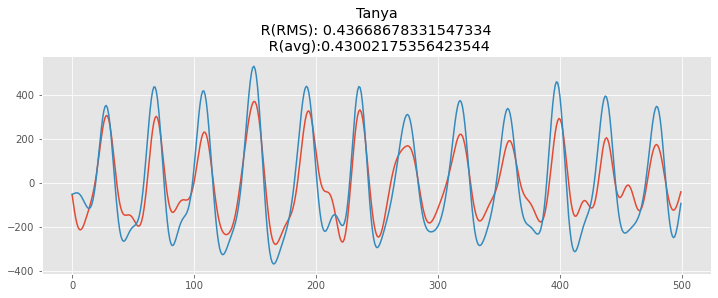

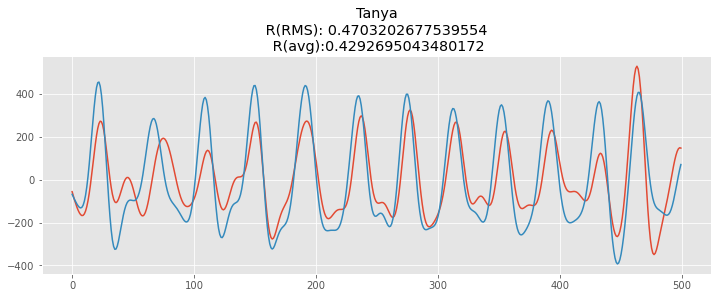

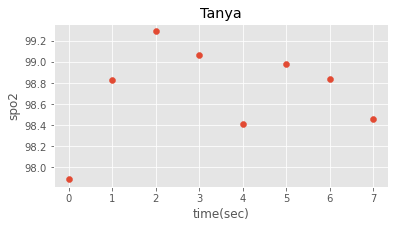

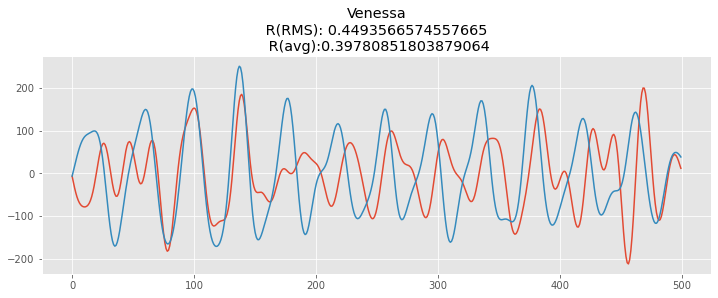

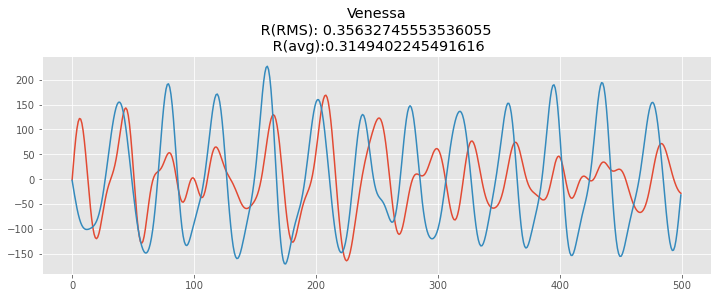

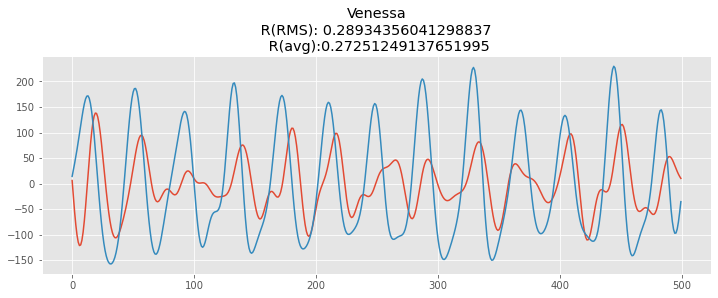

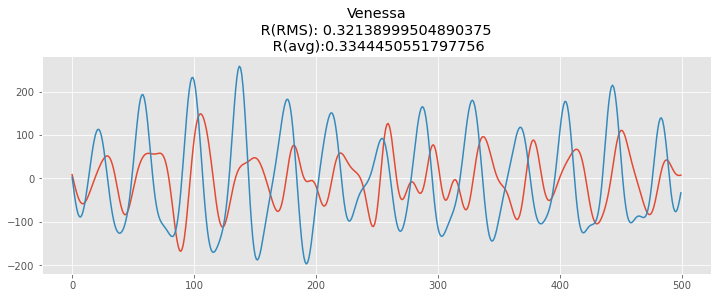

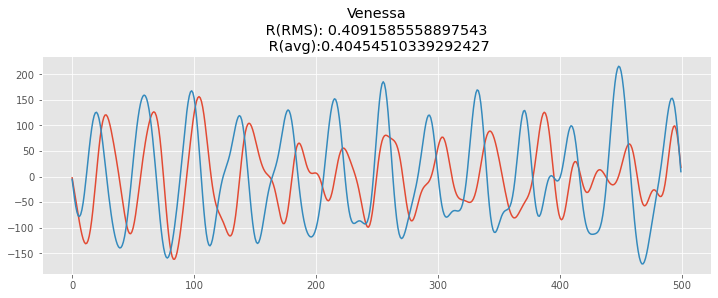

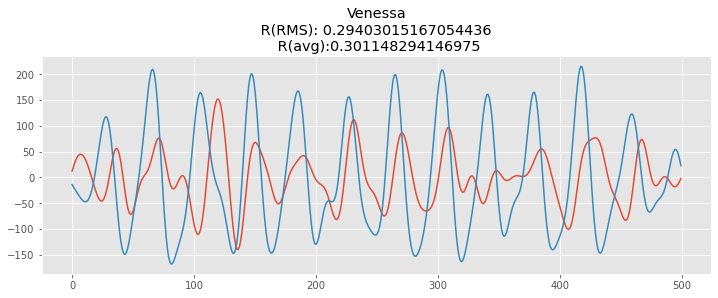

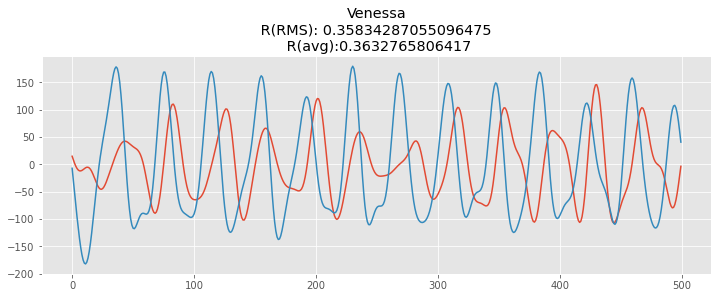

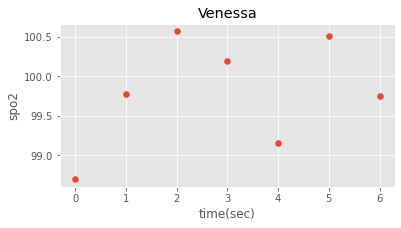

In [17]:

# folder = 'Thor 2.0 BP收集 1220-0103'


folder = 'Thor2 2.0 SPO2 0627'
subjects = ['Coco', 'Jason', 'Nicole', 'Rick', 'Shawn', 'Steven', 'Tanya', 'Venessa']
# subjects = ['Tanya']


# folder = "Thor 2.0 BP收集 1220-0103"
# subjects = ['Coco', 'Gary', 'Jack', 'Molly', 'Nicole', 'Rick', 'Shawn', 'Steven', 'Vanessa']
# subjects = ['Tanya']
# days = ['01','02', '03']
# day = '01' # recored 5 day 01, 02, 03, 04, 05
# meridiem = 'PM'


''' Jing measure SpO2 87% by oximeter on mountain'''
# folder= "Jing0603"
# subjects = ['01', '02', '03']



''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 10
overlap = 0
hop_length = period - overlap

SpO2_table = {
    #'spo2_real':[],
    'spo2':[],
    'criteria':[],
    'R_PI':[],
    'IR_PI':[],
    'R_value':[]
}


''' Overall parameters '''
coeficient = [-12.75886139, 1.39192419]
intercept = 104.14801275562009

sr = 50 # sample rate

# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
lp_b, lp_a = sp.lp_filter(3, sr, 4)


for subject in subjects:
    data = file_read.thor2_reader(os.path.join("../../data/SPO2", folder, subject), 'RawData')
    R = np.array(data['PPG_R'])
    IR = np.array(data['PPG_IR'])
    
    # full_path = os.path.join("../../data", folder, subject, day, meridiem)
    # R = file_read.load_ppg(full_path, 'PPG_R')
    # IR = file_read.load_ppg(full_path, 'PPG_IR')    
    # R = np.array(R)
    # IR = np.array(IR)
    
    per_R = []
    per_Ravg = []
    spo2_list= []         
        
    data_length = len(R)/sr
    num_watching_period = int((data_length - start_sec -overlap)/hop_length) -1
    # num_watching_period = 1
    for n in range(num_watching_period):
        t1 = start_sec +  (period-overlap) * n
        t2 = t1 + period
        s1 = int(t1*sr)
        s2 = int(t2*sr )

        '''''''''''''''''''''''''''''''''''''''
        Signal Preprocessing
        '''''''''''''''''''''''''''''''''''''''
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        
        ''' AC component '''
        IR_AC = signal.filtfilt(bp_b,bp_a, IR_segment)
        R_AC = signal.filtfilt(bp_b, bp_a, R_segment)
        
        ''' DC component '''
        R_DC = signal.filtfilt(lp_b,lp_a, R_segment)
        IR_DC = signal.filtfilt(lp_b,lp_a, IR_segment)

        R_peaks, R_valleys = sp.find_peak_valley(sr, R_AC)
        IR_peaks, IR_valleys = sp.find_peak_valley(sr, IR_AC)
        R_pulse_locs = sp.pulse_seg(R_peaks, R_valleys)
        IR_pulse_locs = sp.pulse_seg(IR_peaks, IR_valleys)
        # R_num_pulse = len(R_pulse_locs) # number of pulse in short segment
        
        R_DC = R_DC - R_AC
        IR_DC = IR_DC - IR_AC

        # per_Rvalue = []
        per_R_PI = []
        per_IR_PI = []
        R_corr = []
        IR_corr = []
        for i in range(len(R_pulse_locs)):
            pLoc = R_pulse_locs[i][1]
            v1 = R_pulse_locs[i][0]
            v2 = R_pulse_locs[i][2]
            R_per_ac = R_AC[pLoc] - ((R_AC[v1]+ R_AC[v2])/2)
            R_per_dc = np.mean(R_DC[v1:v2])
            per_R_PI.append(R_per_ac/R_per_dc)
     
            
            
            
        for pulse in IR_pulse_locs:
            pLoc = pulse[1]
            v1 = pulse[0]
            v2 = pulse[2]
            IR_per_ac = IR_AC[pLoc] - ((IR_AC[v1]+ IR_AC[v2])/2)
            IR_per_dc = np.mean(IR_DC[v1:v2])

            per_IR_PI.append(IR_per_ac/IR_per_dc)
        
        R_PIavg = np.mean(per_R_PI)
        IR_PIavg = np.mean(per_IR_PI)
        Rvalue_avg = R_PIavg/IR_PIavg
        per_Ravg.append(Rvalue_avg)
            
        # per_Rvalue = np.array(per_R_PI)/ np.array(per_IR_PI)
        
        
        ''' Calculate R value by using RMS method'''
        R_divide = R_AC/R_DC
        R_RMS = RMS_amp(R_divide)

        IR_divide = IR_AC/IR_DC
        IR_RMS = RMS_amp(IR_divide)
        R_value = R_RMS/ IR_RMS
        R_squared = R_value*R_value
        spo2 = intercept + (coeficient[0]*R_value) + (coeficient[1]*R_squared)
        spo2_list.append(spo2)
        per_R.append(R_value)
        SpO2_table['spo2'].append(spo2)
        SpO2_table['criteria'].append(subject)
        SpO2_table['R_PI'].append(R_RMS)
        SpO2_table['IR_PI'].append(IR_RMS)
        SpO2_table['R_value'].append(R_value)
        
        '''''''''''''''''''''''''''''''''''
        plot filgure
        '''''''''''''''''''''''''''''''''''
        fig_size  = (12,4)
            
        plt.figure(figsize=fig_size)
        plt.title('{}\n R(RMS): {} \n R(avg):{}'.format(subject, R_value, Rvalue_avg))
        
        plt.plot(R_AC, label='R')
        plt.plot(IR_AC, label='IR')

        # plt.plot(R_peaks, R_AC[R_peaks], '*', color='r')
        # plt.plot(R_valleys, R_AC[R_valleys], '*', color='blue')
        # plt.legend()

        # for i in range(len(R_pulse_locs)):
        #     p = R_pulse_locs[i][1]
        #     plt.text(p, R_AC[p], str(np.round(per_R_PI[i] *1000,2)))
        
        
        # for i in range(len(IR_pulse_locs)):
        #     p = IR_pulse_locs[i][1]
        #     plt.text(p, IR_AC[p], str(np.round(per_IR_PI[i]*1000,2)))
    
        
        # show DC component 
        # plt.plot(R_DC, label='R')
        # plt.plot(IR_DC, label='IR')

        # plt.plot(R_peaks, R_DC[R_peaks], '*', color='r')
        # plt.plot(R_valleys, R_DC[R_valleys], '*', color='blue')
        
        # for i in range(len(R_pulse_locs)):
        #     p = R_pulse_locs[i][1]
        #     plt.text(p, R_DC[p], str(np.round(per_R_PI[i] *1000,2)))
        
        
        # for i in range(len(IR_pulse_locs)):
        #     p = IR_pulse_locs[i][1]
        #     plt.text(p, IR_DC[p], str(np.round(per_IR_PI[i]*1000,2)))
        # plt.legend()
        
    ''' Trend of R value '''

    plt.figure(figsize=(6,3))
    plt.title(subject)
    plt.scatter(np.arange(len(spo2_list)), spo2_list)
    # plt.ylim(95, 100)
    # plt.scatter(np.arange(len(per_R)), per_R, label='RMS')
    # plt.scatter(np.arange(len(per_Ravg)), per_Ravg, label='avg')
    
    plt.xlabel('time(sec)')
    plt.ylabel('spo2')
    # plt.legend()
    


0.20224719101123595

In [4]:
import pandas as pd

df = pd.DataFrame(SpO2_table)
df


spo2 criteria      R_PI     IR_PI   R_value
0    96.096626     Coco  0.000137  0.000201  0.681748
1    95.897321     Coco  0.000147  0.000210  0.700142
2    96.247802     Coco  0.000135  0.000202  0.667853
3    95.807945     Coco  0.000152  0.000214  0.708419
4    95.275865     Coco  0.000152  0.000201  0.758064
..         ...      ...       ...       ...       ...
58  100.572850  Venessa  0.000032  0.000111  0.289344
59  100.191216  Venessa  0.000036  0.000113  0.321390
60   99.160638  Venessa  0.000040  0.000098  0.409159
61  100.516860  Venessa  0.000032  0.000109  0.294030
62   99.754702  Venessa  0.000035  0.000098  0.358343

[63 rows x 5 columns]

In [20]:
for i,v in enumerate(R_pulse_locs):
    print(i, v)

0 [50, 58, 65]
1 [65, 78, 103]
2 [103, 119, 137]
3 [137, 160, 174]
4 [174, 199, 215]
5 [215, 237, 255]
6 [255, 276, 292]
7 [292, 318, 333]
8 [333, 358, 377]
9 [377, 397, 416]
10 [416, 435, 457]


In [21]:
[1,2,3]/[2,2,2]

TypeError: unsupported operand type(s) for /: 'list' and 'list'